<h1 align="center">Semantic Image Segmentation based on 
Fully Convolutional Network (FCNs) </h1>
<h2 align="center">CIE 552 - Spring 2021 </h>

An implementation of the paper : **["Fully Convolutional Networks for Semantic Segmentation"](https://arxiv.org/pdf/1411.4038.pdf)**





*J. Long, E. Shelhamer, and T. Darrell, “Fully convolutional networks for semantic segmentation,” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015.*

In [ ]:
'''This block and the following are just to check if the 
    runtime is chosen correctly ''' 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select "Runtime" -> "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul  2 08:58:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#Import Libraries

In [ ]:
!pip install np_utils
import cv2
import numpy as np
from PIL import Image
import h5py
import os
import random
import threading
import queue
import string
import matplotlib.pyplot as plt
import datetime
import io
import json

import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation, Conv2DTranspose, Add, ZeroPadding2D, Cropping2D
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Pre-Processing & Loading Dataset

In [ ]:
#Class for Dataset Preparation

class VOC2012:
    def __init__(self, root_path='/content/drive/MyDrive/VOC2012', image_size=(224, 224), resize_method='resize'):
        '''
        This function allows for the creation of a VOC2012 object containing the dataset with relevant functions
        Args:
            root_path: the Pascal VOC 2012 folder path
            image_size: resize all images and labels into this size
        '''
        self.root_path = root_path
        self.resize_method = resize_method

        if root_path[len(root_path) - 1] != '/' and root_path[len(root_path) - 1] != '\\':
            self.root_path += '/'
        self.train_names_path = self.root_path + 'ImageSets/Segmentation/train.txt'
        self.val_names_path = self.root_path + 'ImageSets/Segmentation/val.txt'
        self.image_path = self.root_path + 'JPEGImages/'
        self.label_path = self.root_path + 'SegmentationClass/'
        self.image_size = image_size
        if os.path.isfile(self.train_names_path):
            self.read_train_names()
        if os.path.isfile(self.val_names_path):
            self.read_val_names()

    def read_train_names(self):
        '''
        Read the filenames of training images and labels into self.train_list
        '''
        self.train_names = []
        f = open(self.train_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.train_names.append(line)
        f.close()

    def read_val_names(self):
        '''
        Read the filenames of validation images and labels into self.val_list
        '''
        self.val_names = []
        f = open(self.val_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.val_names.append(line)
        f.close()
        

    def get_train(self):
        '''
        Returns a "tuple" of lists containg all of the training images & labels respectively ... each element in each of the lists is a 224x224x3 numpy array representing an image.
        '''
        batch_images = []
        batch_labels = []

        for i in range(int(len(self.train_names))):
            image = cv2.imread(self.image_path + self.train_names[i] + '.jpg')
            if self.image_size:
                image = cv2.resize(image, self.image_size)
            label = np.array(Image.open(self.label_path + self.train_names[i] + '.png'))
            label[label > 20] = 0
            if self.image_size:
                label = cv2.resize(label, self.image_size, interpolation=cv2.INTER_NEAREST)
            batch_images.append(image)
            batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)

    def get_val(self):
        '''
        Returns a "tuple" of lists containg all of the validation images & labels respectively ... each element in each of the lists is a 224x224x3 numpy array representing an image.
        '''        
        batch_images = []
        batch_labels = []

        for i in range(int(len(self.val_names))):
            image = cv2.imread(self.image_path + self.val_names[i] + '.jpg')
            if self.image_size:
                image = cv2.resize(image, self.image_size)
            label = np.array(Image.open(self.label_path + self.val_names[i] + '.png'))
            label[label > 20] = 0
            if self.image_size:
                label = cv2.resize(label, self.image_size, interpolation=cv2.INTER_NEAREST)
            batch_images.append(image)
            batch_labels.append(label)
        return np.array(batch_images), np.array(batch_labels)


    def read_all_data_and_save(self, train_data_save_path='/content/drive/MyDrive/CVproject/voc2012_train.h5', val_data_save_path='./voc2012_val.h5'):
        '''
        Read training and validation data and save them into two .h5 files.
        Args:
            train_data_save_path:The path you want to save training data into.
            val_data_save_path:The path you want to save validation data into.
        '''
        self.read_train_images()
        self.read_train_labels()
        self.read_val_images()
        self.read_val_labels()
        self.save_train_data(train_data_save_path)
        self.save_val_data(val_data_save_path)

    def save_train_data(self, path='/content/drive/MyDrive/CVproject/voc2012_train.h5'):
        '''
        save training images and labels into path in the form of .h5
        Args:
            path:The path you want to save train data into.It must be xxx.h5
        '''
        save_h5(path, self.train_images, self.train_labels)

    def save_val_data(self, path='/content/drive/MyDrive/CVproject/voc2012_val.h5'):
        '''
        save validation images and labels into path in the form of .h5
        Args:
            path:The path you want to save train data into.It must be xxx.h5
        '''
        save_h5(path, self.val_images, self.val_labels)

    def save_h5(self, path ,images, labels ):
      with h5py.File(path,'w') as hdf:
        hdf.create_dataset('images',data=images)
        hdf.create_dataset('labels',data=labels)



    def load_all_data(self, train_data_load_path='/content/drive/MyDrive/CVproject/voc2012_train.h5', val_data_load_path='/content/drive/MyDrive/CVproject/voc2012_val.h5'):
        '''
        Load training and validation data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
            val_data_load_path:The validation data .h5 file path.
        '''
        self.load_train_data(train_data_load_path)
        self.load_val_data(val_data_load_path)

    def read_train_images(self):
        '''
        Read training images into self.train_images
        If you haven't called self.read_train_list(), it will call first
        After reading images, it will resize them
        '''
        self.train_images = []
        if hasattr(self, 'train_list') == False:
            self.read_train_list()
        for filename in self.train_list:
            image = cv2.imread(self.image_path + filename + '.jpg')
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            self.train_images.append(image)
            if len(self.train_images) % 100 == 0:
                print('Reading train images', len(self.train_images), '/', len(self.train_list))

    def read_train_labels(self):
        '''
        Read training labels into self.train_labels
        If you haven't called self.read_train_list(), it will call first
        After reading labels, it will resize them
        Note:image[image > 20] = 0 will remove all white borders in original labels
        '''
        self.train_labels = []
        if hasattr(self, 'train_list') == False:
            self.read_train_list()
        for filename in self.train_list:
            image = Image.open(self.label_path + filename + '.png')
            image = np.array(image)
            image[image > 20] = 0
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            image[image > 20] = 0
            self.train_labels.append(image)
            if len(self.train_labels) % 100 == 0:
                print('Reading train labels', len(self.train_labels), '/', len(self.train_list))

    def read_val_images(self):
        '''
           Read validation images into self.val_images
           If you haven't called self.read_val_list(), it will call first
           After reading images, it will resize them
        '''
        self.val_images = []
        if hasattr(self, 'val_list') == False:
            self.read_val_list()
        for filename in self.val_list:
            image = cv2.imread(self.image_path + filename + '.jpg')
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            self.val_images.append(image)
            if len(self.val_images) % 100 == 0:
                print('Reading val images', len(self.val_images), '/', len(self.val_list))

    def read_val_labels(self):
        '''
           Read validation labels into self.val_labels
           If you haven't called self.read_val_list(), it will call first
           After reading labels, it will resize them
           Note:image[image > 100] = 0 will remove all white borders in original labels
        '''
        self.val_labels = []
        if hasattr(self, 'val_list') == False:
            self.read_val_list()
        for filename in self.val_list:
            image = Image.open(self.label_path + filename + '.png')
            image = np.array(image)
            image[image > 20] = 0
            if self.resize_method == 'resize':
                image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
            elif self.resize_method == 'pad':
                height = np.shape(image)[0]
                width = np.shape(image)[1]
                image = cv2.copyMakeBorder(image, 0, 500 - height, 0, 500 - width, cv2.BORDER_CONSTANT, value=0)
            image[image > 20] = 0
            self.val_labels.append(image)
            if len(self.val_labels) % 100 == 0:
                print('Reading val labels', len(self.val_labels), '/', len(self.val_list))

    def read_train_list(self):
        '''
        Read the filenames of training images and labels into self.train_list
        '''
        self.train_list = []
        f = open(self.train_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.train_list.append(line)
        f.close()
    
    def read_val_list(self):
        '''
        Read the filenames of validation images and labels into self.val_list
        '''
        self.val_list = []
        f = open(self.val_names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n', '')
            if line is None or len(line) == 0:
                break
            self.val_list.append(line)
        f.close()

    def load_all_data(self, train_data_load_path='/content/drive/MyDrive/CVproject/voc2012_train.h5', val_data_load_path='/content/drive/MyDrive/CVproject/voc2012_val.h5'):
        '''
        Load training and validation data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
            val_data_load_path:The validation data .h5 file path.
        '''
        self.load_train_data(train_data_load_path)
        self.load_val_data(val_data_load_path)

    def load_train_data(self, path='./content/drive/MyDrive/CVproject/voc2012_train.h5'):
        '''
        Load training data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
        '''
        self.train_images, self.train_labels = load_h5(path)

    def load_val_data(self, path='/content/drive/MyDrive/CVproject/voc2012_val.h5'):
        '''
        Load validation data from .h5 files
        Args:
            val_data_load_path:The validation data .h5 file path.
        '''
        self.val_images, self.val_labels = load_h5(path)

# Loading data from dataset

def save_h5(path,images,labels):
  print("saving h5")
  with h5py.File(path,'w') as hdf:
    hdf.create_dataset('images',data=images)
    hdf.create_dataset('labels',data=labels)

def load_h5(path):
	print('loading',path)
	file = h5py.File(name=path,mode='r')
	return file['images'],file['labels']

def load_train_data(path='/content/drive/MyDrive/CVproject/voc2012_train.h5'):
        '''
        Load training data from .h5 files
        Args:
            train_data_load_path:The training data .h5 file path.
        '''
        return load_h5(path)

def load_val_data(path='/content/drive/MyDrive/CVproject/voc2012_val.h5'):
        '''
        Load validation data from .h5 files
        Args:
            val_data_load_path:The validation data .h5 file path.
        '''
        return load_h5(path)


##Utilities

In [ ]:
def parse_example(example):
    '''Parse tf Example to obtain image and label.    
    '''
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    feature_dict = tf.io.parse_single_example(example, feature_description)
    height,width = feature_dict['height'],feature_dict['width']
    image = tf.reshape(tf.io.decode_raw(feature_dict['image'], out_type=tf.uint8), (height, width, 3))
    label = tf.reshape(tf.io.decode_raw(feature_dict['label'], out_type=tf.uint8), (height, width, 1))
    return image, label

def resize(image, label, size=512):
    '''Resize with pad and keep aspect ratio'''
    image = tf.image.resize_with_pad(image, size, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.image.resize_with_pad(label+1, size, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)-1
    return image, label
    
def Extract_dataset():
  def mapper(example):
      image, label = parse_example(example)
      return resize(image, label) # no augmentation

  train_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/VOC2011_all/train.tfrecords').map(mapper)
  val_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/VOC2011_all/val.tfrecords').map(mapper)
  return train_dataset,val_dataset

def arg_max_label(pred):
    '''Opposite of label_to_onehot().'''
    pred = np.argmax(pred, axis=-1).astype(np.uint8)
    return pred[..., None]

def Retrieve_label_mat(path):
    '''Retrieve class labels for each pixel from Berkeley SBD .mat file.'''
    mat_file = scipy.io.loadmat(path)
    mat_label = mat_file['GTcls']['Segmentation'].item(0,0) # Berkely SBD mat convention
    return mat_label[..., None]

def read_image(path):
    '''Retrieve image as array of RGB values from .jpg file.
    '''
    img = Image.open(path).convert('RGB')
    return np.array(img)

#mapping colors
PALETTE = np.reshape([
    0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128,
    128, 128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0,
    128, 192, 0, 128, 64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0,
    192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128,
    64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0, 64, 64, 128, 192, 64, 128,
    64, 192, 128, 192, 192, 128, 0, 0, 64, 128, 0, 64, 0, 128, 64, 128, 128,
    64, 0, 0, 192, 128, 0, 192, 0, 128, 192, 128, 128, 192, 64, 0, 64, 192, 0,
    64, 64, 128, 64, 192, 128, 64, 64, 0, 192, 192, 0, 192, 64, 128, 192, 192,
    128, 192, 0, 64, 64, 128, 64, 64, 0, 192, 64, 128, 192, 64, 0, 64, 192,
    128, 64, 192, 0, 192, 192, 128, 192, 192, 64, 64, 64, 192, 64, 64, 64, 192,
    64, 192, 192, 64, 64, 64, 192, 192, 64, 192, 64, 192, 192, 192, 192, 192,
    32, 0, 0, 160, 0, 0, 32, 128, 0, 160, 128, 0, 32, 0, 128, 160, 0, 128, 32,
    128, 128, 160, 128, 128, 96, 0, 0, 224, 0, 0, 96, 128, 0, 224, 128, 0, 96,
    0, 128, 224, 0, 128, 96, 128, 128, 224, 128, 128, 32, 64, 0, 160, 64, 0,
    32, 192, 0, 160, 192, 0, 32, 64, 128, 160, 64, 128, 32, 192, 128, 160, 192,
    128, 96, 64, 0, 224, 64, 0, 96, 192, 0, 224, 192, 0, 96, 64, 128, 224, 64,
    128, 96, 192, 128, 224, 192, 128, 32, 0, 64, 160, 0, 64, 32, 128, 64, 160,
    128, 64, 32, 0, 192, 160, 0, 192, 32, 128, 192, 160, 128, 192, 96, 0, 64,
    224, 0, 64, 96, 128, 64, 224, 128, 64, 96, 0, 192, 224, 0, 192, 96, 128,
    192, 224, 128, 192, 32, 64, 64, 160, 64, 64, 32, 192, 64, 160, 192, 64, 32,
    64, 192, 160, 64, 192, 32, 192, 192, 160, 192, 192, 96, 64, 64, 224, 64,
    64, 96, 192, 64, 224, 192, 64, 96, 64, 192, 224, 64, 192, 96, 192, 192,
    224, 192, 192, 0, 32, 0, 128, 32, 0, 0, 160, 0, 128, 160, 0, 0, 32, 128,
    128, 32, 128, 0, 160, 128, 128, 160, 128, 64, 32, 0, 192, 32, 0, 64, 160,
    0, 192, 160, 0, 64, 32, 128, 192, 32, 128, 64, 160, 128, 192, 160, 128, 0,
    96, 0, 128, 96, 0, 0, 224, 0, 128, 224, 0, 0, 96, 128, 128, 96, 128, 0,
    224, 128, 128, 224, 128, 64, 96, 0, 192, 96, 0, 64, 224, 0, 192, 224, 0,
    64, 96, 128, 192, 96, 128, 64, 224, 128, 192, 224, 128, 0, 32, 64, 128, 32,
    64, 0, 160, 64, 128, 160, 64, 0, 32, 192, 128, 32, 192, 0, 160, 192, 128,
    160, 192, 64, 32, 64, 192, 32, 64, 64, 160, 64, 192, 160, 64, 64, 32, 192,
    192, 32, 192, 64, 160, 192, 192, 160, 192, 0, 96, 64, 128, 96, 64, 0, 224,
    64, 128, 224, 64, 0, 96, 192, 128, 96, 192, 0, 224, 192, 128, 224, 192, 64,
    96, 64, 192, 96, 64, 64, 224, 64, 192, 224, 64, 64, 96, 192, 192, 96, 192,
    64, 224, 192, 192, 224, 192, 32, 32, 0, 160, 32, 0, 32, 160, 0, 160, 160,
    0, 32, 32, 128, 160, 32, 128, 32, 160, 128, 160, 160, 128, 96, 32, 0, 224,
    32, 0, 96, 160, 0, 224, 160, 0, 96, 32, 128, 224, 32, 128, 96, 160, 128,
    224, 160, 128, 32, 96, 0, 160, 96, 0, 32, 224, 0, 160, 224, 0, 32, 96, 128,
    160, 96, 128, 32, 224, 128, 160, 224, 128, 96, 96, 0, 224, 96, 0, 96, 224,
    0, 224, 224, 0, 96, 96, 128, 224, 96, 128, 96, 224, 128, 224, 224, 128, 32,
    32, 64, 160, 32, 64, 32, 160, 64, 160, 160, 64, 32, 32, 192, 160, 32, 192,
    32, 160, 192, 160, 160, 192, 96, 32, 64, 224, 32, 64, 96, 160, 64, 224,
    160, 64, 96, 32, 192, 224, 32, 192, 96, 160, 192, 224, 160, 192, 32, 96,
    64, 160, 96, 64, 32, 224, 64, 160, 224, 64, 32, 96, 192, 160, 96, 192, 32,
    224, 192, 160, 224, 192, 96, 96, 64, 224, 96, 64, 96, 224, 64, 224, 224,
    64, 96, 96, 192, 224, 96, 192, 96, 224, 192, 224, 224, 192], (-1, 3))

def label_to_image(label, palette=PALETTE):
    '''Converts class labels to color image using a palette.
    '''
    return palette[label[..., 0]].astype(np.uint8)

def Eval_show_sample(img_orig, label_orig, model):
  img, label = resize(img_orig, label_orig)
  y_pred = model(img[None])[0]
  _ = model.evaluate(img[None], label[None])

  y_pred = tf.image.resize_with_crop_or_pad(y_pred, label_orig.shape[0], label_orig.shape[1])
  y_pred = arg_max_label(y_pred)

  plt.figure()
  plt.imshow(label_to_image(label_orig))
  plt.show()

  plt.figure()
  plt.imshow(label_to_image(y_pred))
  plt.savefig('/content/y_pred.png')
  plt.show()


##Losses & Evaluation Metrics

In [ ]:
def cross_entropy(label, pred):
    '''Custom cross-entropy to handle borders (class = -1).'''
    n = tf.math.reduce_sum(tf.cast(label != 255, tf.float32))
    y_true_onehot = tf.cast(np.arange(21) == label, tf.float32)
    return tf.reduce_sum(-y_true_onehot * tf.math.log(pred + 1e-7)) / n
    
    
def pixel_accuracy(label, pred):
    '''Custom pixel accuracy to handle borders (class = -1).'''
    n = tf.math.reduce_sum(tf.cast(label != 255, tf.float32))
    label = tf.cast(label, tf.int32)[..., 0]
    pred = tf.argmax(pred, axis=-1, output_type=tf.int32)
    return tf.reduce_sum(tf.cast(label == pred, tf.float32)) / n



class Mean_IoU(keras.metrics.MeanIoU):
    '''Custom meanIoU to handle borders (class = -1).'''
    def update_state(self,label, pred, sample_weight=None):
        pred = tf.argmax(pred, axis=-1)
        ## add 1 so boundary class=0
        label = tf.cast(label+1, self._dtype)
        pred = tf.cast(pred+1, self._dtype)
        ## Flatten the input if its rank > 1.
        if pred.shape.ndims > 1:
            pred = tf.reshape(pred, [-1])
        if label.shape.ndims > 1:
            label = tf.reshape(label, [-1])
        ## calculate confusion matrix with one extra class
        current_cm = tf.math.confusion_matrix(
            label,
            pred,
            self.num_classes+1,
            weights=sample_weight, #non-weighted IOU
            dtype=self._dtype)
        return self.total_cm.assign_add(current_cm[1:, 1:]) # remove boundary

#Models

In [ ]:
#Fully Convolutional Networks Class, Implementing FCN_32 & FCN_8s
class FCN():
  def __init__(self):
    self.encoder= self.VGG_encoder(input_height=None, input_width=None, channels=3)
    self.fcn_32= self.FCN_32(21,self.VGG_encoder,input_height=None, input_width=None, channels=3)
    self.fcn_8s= self.FCN_8s(21,self.VGG_encoder,input_height=None, input_width=None, channels=3)

  def VGG_encoder(self,input_height=None, input_width=None, channels=3,l2=1e-6, drop_p=0.2):
    
    Data_shape = 'channels_last'
    img_input = Input(shape=(input_height, input_width, channels))
    x=keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name='preprocessing')(img_input)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.L2(l2=l2), padding='same',
               name='block1_conv1', data_format=Data_shape)(x)
    x = Conv2D(64, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.L2(l2=l2), padding='same',
               name='block1_conv2', data_format=Data_shape)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block1_pool',
                     data_format=Data_shape)(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block2_conv1', data_format=Data_shape)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block2_conv2', data_format=Data_shape)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block2_pool',
                     data_format=Data_shape)(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block3_conv1', data_format=Data_shape)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block3_conv2', data_format=Data_shape)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block3_conv3', data_format=Data_shape)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block3_pool',
                     data_format=Data_shape)(x)
    bool3_skip = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block4_conv1', data_format=Data_shape)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block4_conv2', data_format=Data_shape)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block4_conv3', data_format=Data_shape)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block4_pool',
                     data_format=Data_shape)(x)
    bool4_skip = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block5_conv1', data_format=Data_shape)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block5_conv2', data_format=Data_shape)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.L2(l2=l2),
               name='block5_conv3', data_format=Data_shape)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='block5_pool',
                     data_format=Data_shape)(x)

    #Convlutionize the fully-connected layers

    o = (Conv2D(4096, (7, 7), activation='relu',kernel_regularizer=keras.regularizers.L2(l2=l2),
                padding='same', data_format=Data_shape))(x)
    o = Dropout(drop_p)(o)
    o = (Conv2D(4096, (1, 1), activation='relu',kernel_regularizer=keras.regularizers.L2(l2=l2),
                padding='same', data_format=Data_shape))(o)
    output = Dropout(drop_p)(o)    
    
    #Last cnvolution with 1000 class not included
    o = keras.layers.Conv2D(filters=1000, kernel_size=(1,1), strides=(1,1), padding='same', activation='softmax', 
                            name='pred')(output)                 

    model = keras.Model(img_input, o)

    vgg_weights = VGG16(weights='imagenet').get_weights()
    vgg_weights[26] = vgg_weights[26].reshape(7, 7, 512, 4096)
    vgg_weights[28] = vgg_weights[28].reshape(1, 1, 4096, 4096)
    vgg_weights[30] = vgg_weights[30].reshape(1, 1, 4096, 1000)
    model.set_weights(vgg_weights)
    del vgg_weights
    
    return img_input, [bool3_skip,bool4_skip, output]

  def FCN_32(self,n_classes, base_encoder,input_height=None, input_width=None, channels=3, l2=1e-6):
    Data_shape = 'channels_last'
    input, bool_layers = base_encoder(input_height=input_height, input_width=input_width, channels=channels)
    _,_,out = bool_layers

    o = (Conv2D(n_classes, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_regularizer=keras.regularizers.L2(l2=l2),data_format=Data_shape))(out)

    o =  Conv2DTranspose(n_classes, kernel_size=(64,64), strides=(32,32),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2), data_format=Data_shape, trainable=False)(o)

   
    fcn_32= Model(input, o)
    return fcn_32

  def FCN_8s(self,n_classes, base_encoder,input_height=None, input_width=None, channels=3, l2=1e-6):

    Data_shape = 'channels_last'
    input, bool_layers = base_encoder(input_height=input_height, input_width=input_width, channels=channels)
    bool3,bool4,out = bool_layers


    

    o = (Conv2D(n_classes,  (1, 1), padding='same', activation='linear',
                            kernel_regularizer=keras.regularizers.L2(l2=l2),data_format=Data_shape))(out)

    o = Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2), data_format=Data_shape, trainable=False)(o)

    o2 = bool4
    o2 = (Conv2D(n_classes, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                data_format=Data_shape))(o2)


    o = Add()([o, o2])

    o = Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2), data_format=Data_shape, trainable=False)(o)

    o2 = bool3
    o2 = (Conv2D(n_classes, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                data_format=Data_shape))(o2)
    o = Add( name="fuse" )([o, o2])

    o = Conv2DTranspose(n_classes, kernel_size=(16,16), strides=(8,8),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2), data_format=Data_shape, trainable=False)(o)

   
    fcn_8s= Model(input, o)
    return fcn_8s

class BilinearInitializer(keras.initializers.Initializer):
    '''Initializer for Conv2DTranspose to perform bilinear interpolation on each channel.'''
    def __call__(self, shape, dtype=None, **kwargs):
        kernel_size, _, filters, _ = shape
        arr = np.zeros((kernel_size, kernel_size, filters, filters))
        ## make filter that performs bilinear interpolation through Conv2DTranspose
        upscale_factor = (kernel_size+1)//2
        if kernel_size % 2 == 1:
            center = upscale_factor - 1
        else:
            center = upscale_factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        kernel = (1-np.abs(og[0]-center)/upscale_factor) * \
                 (1-np.abs(og[1]-center)/upscale_factor) # kernel shape is (kernel_size, kernel_size)
        for i in range(filters):
            arr[..., i, i] = kernel
        return tf.convert_to_tensor(arr, dtype=dtype)

In [ ]:
models=FCN()
fcn32_model= models.fcn_32
fcn8s_model= models.fcn_8s

In [ ]:
fcn32_model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
preprocessing (Lambda)       (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147

In [ ]:
# Mount to drive
# Uncomment If needed
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Mounted at /content/drive


#Training

In [ ]:
#Extract Training & Validation datasets from TFrecords in Google drive :https://drive.google.com/drive/folders/1qQyXQTqyQaDeT5pB5F8Ypxpn7yZPrYyo?usp=sharing
train_dataset, val_dataset = Extract_dataset()
train = train_dataset.shuffle(1000).batch(16) #batch size= 16 
val = val_dataset.shuffle(1000).batch(16) 

In [ ]:
#FCN_32 Training
#Choose Optimizer, Loss, Metrics
opt = Adam(1e-4)
loss = cross_entropy
metrics = [loss, pixel_accuracy, Mean_IoU(num_classes=21, name='mean_IoU')]

#Compile model
fcn32_model.compile(optimizer=opt, loss=loss, metrics=metrics)

#Fit 
history = fcn32_model.fit(train, epochs=12, validation_data=val)

Epoch 1/12
677/677 [==============================] - 880s 1s/step - loss: 0.8570 - cross_entropy: 0.8449 - pixel_accuracy: 0.7758 - mean_IoU: 0.1724 - val_loss: 0.5394 - val_cross_entropy: 0.5271 - val_pixel_accuracy: 0.8344 - val_mean_IoU: 0.3302
Epoch 2/12
677/677 [==============================] - 878s 1s/step - loss: 0.5103 - cross_entropy: 0.4980 - pixel_accuracy: 0.8459 - mean_IoU: 0.3849 - val_loss: 0.4591 - val_cross_entropy: 0.4465 - val_pixel_accuracy: 0.8595 - val_mean_IoU: 0.4284
Epoch 3/12
677/677 [==============================] - 849s 1s/step - loss: 0.3953 - cross_entropy: 0.3826 - pixel_accuracy: 0.8755 - mean_IoU: 0.4972 - val_loss: 0.4337 - val_cross_entropy: 0.4206 - val_pixel_accuracy: 0.8656 - val_mean_IoU: 0.4469
Epoch 4/12
677/677 [==============================] - 848s 1s/step - loss: 0.3301 - cross_entropy: 0.3169 - pixel_accuracy: 0.8926 - mean_IoU: 0.5662 - val_loss: 0.4159 - val_cross_entropy: 0.4023 - val_pixel_accuracy: 0.8742 - val_mean_IoU: 0.4862
Epoc

In [ ]:
import pickle
fcn32_model.save_weights('/content/drive/MyDrive/VOC2011_all/FCN_32/fcn_32_1.h5')

with open('/content/drive/MyDrive/VOC2011_all/FCN_32/fcn_32_1', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
#FCN_8s Training
#Choose Optimizer, Loss, Metrics
opt = Adam(1e-4)
loss = cross_entropy
metrics = [loss, pixel_accuracy, MeanIoU(num_classes=21, name='mean_IoU')]

#Compile model
fcn8s_model.compile(optimizer=opt, loss=loss, metrics=metrics)

#Fit 
history = fcn8s_model.fit(train, epochs=20, validation_data=val)


Epoch 1/30
677/677 [==============================] - 548s 795ms/step - loss: 1.2808 - crossentropy: 1.2776 - pixelacc: 0.7275 - meanIoU: 0.1019 - val_loss: 0.6307 - val_crossentropy: 0.6275 - val_pixelacc: 0.8145 - val_meanIoU: 0.2574
Epoch 2/30
677/677 [==============================] - 544s 794ms/step - loss: 0.5955 - crossentropy: 0.5923 - pixelacc: 0.8217 - meanIoU: 0.2858 - val_loss: 0.4587 - val_crossentropy: 0.4553 - val_pixelacc: 0.8582 - val_meanIoU: 0.3983
Epoch 3/30
677/677 [==============================] - 544s 795ms/step - loss: 0.4656 - crossentropy: 0.4621 - pixelacc: 0.8547 - meanIoU: 0.4069 - val_loss: 0.4335 - val_crossentropy: 0.4298 - val_pixelacc: 0.8622 - val_meanIoU: 0.4626
Epoch 4/30
677/677 [==============================] - 546s 797ms/step - loss: 0.3746 - crossentropy: 0.3708 - pixelacc: 0.8787 - meanIoU: 0.5030 - val_loss: 0.4057 - val_crossentropy: 0.4017 - val_pixelacc: 0.8728 - val_meanIoU: 0.4583
Epoch 5/30
677/677 [==============================] - 54

KeyboardInterrupt: ignored

#Evaluation

1/1 [==============================] - 0s 80ms/step - loss: 0.0943 - cross_entropy: 0.0759 - pixel_accuracy: 0.9739 - mean_IoU: 0.8122


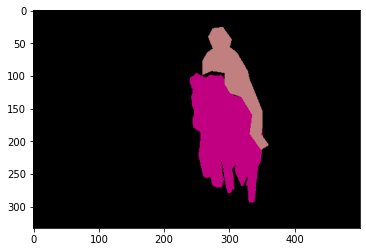

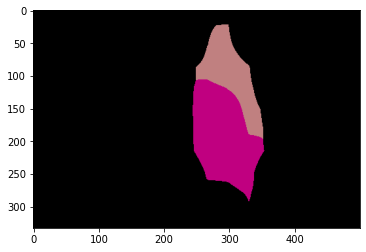

In [ ]:
#FCN32
import scipy
from scipy import io
img_o = read_image('/content/rider.jpg')
label_o =Retrieve_label_mat('/content/rider_label.mat')
Eval_show_sample(img_o, label_o, fcn32_model)

1/1 [==============================] - 0s 84ms/step - loss: 0.1779 - cross_entropy: 0.1594 - pixel_accuracy: 0.9501 - mean_IoU: 0.4516


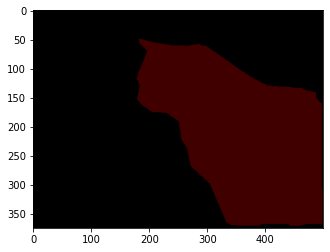

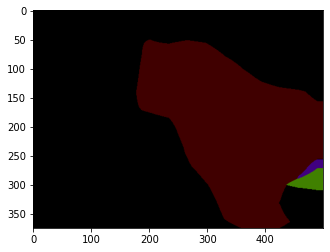

In [ ]:
#FCN32
import scipy
from scipy import io
img_o = read_image('/content/2008_001885.jpg')
label_o =Retrieve_label_mat('/content/2008_001885.mat')
Eval_show_sample(img_o, label_o, fcn32_model)

1/1 [==============================] - 0s 82ms/step - loss: 0.1840 - cross_entropy: 0.1655 - pixel_accuracy: 0.9345 - mean_IoU: 0.8647


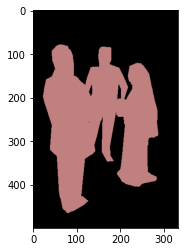

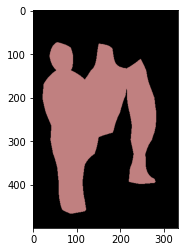

In [ ]:
#FCN32
img_o = read_image('/content/2008_000475.jpg')
label_o =Retrieve_label_mat('/content/2008_000475.mat')
Eval_show_sample(img_o, label_o, fcn32_model)

In [ ]:
#load FCN_8s model weights 
fcn8_load= models.fcn_8s
fcn8_load.load_weights('/content/drive/MyDrive/VOC2011_all/FCN_8s/fcn_8s_2.h5')
fcn8_load.compile(optimizer=opt, loss=loss, metrics=metrics)


1/1 [==============================] - 0s 80ms/step - loss: 0.0716 - cross_entropy: 0.0612 - pixel_accuracy: 0.9762 - mean_IoU: 0.8125


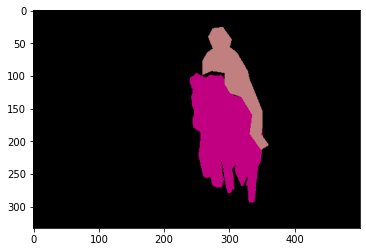

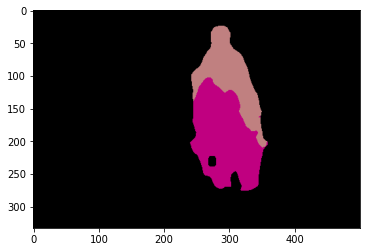

In [ ]:
#FCN_8s
img_o = read_image('/content/rider.jpg')
label_o =Retrieve_label_mat('/content/rider_label.mat')
Eval_show_sample(img_o, label_o, fcn8_load)

1/1 [==============================] - 0s 81ms/step - loss: 0.0738 - cross_entropy: 0.0633 - pixel_accuracy: 0.9768 - mean_IoU: 0.6347


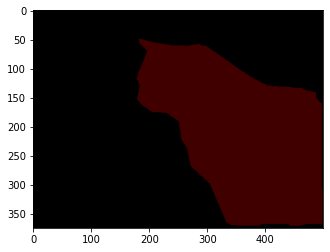

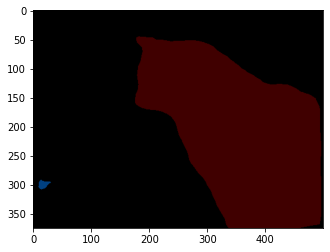

In [ ]:
#FCN_8s
img_o = read_image('/content/2008_001885.jpg')
label_o =Retrieve_label_mat('/content/2008_001885.mat')
Eval_show_sample(img_o, label_o, fcn8_load)

1/1 [==============================] - 0s 81ms/step - loss: 0.1256 - cross_entropy: 0.1151 - pixel_accuracy: 0.9549 - mean_IoU: 0.9054


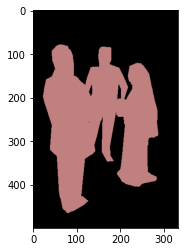

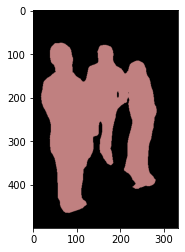

In [ ]:
#FCN_8s
img_o = read_image('/content/2008_000475.jpg')
label_o =Retrieve_label_mat('/content/2008_000475.mat')
Eval_show_sample(img_o, label_o, fcn8_load)

In [ ]:
#Load models history 
with open('/content/drive/MyDrive/VOC2011_all/FCN_32/fcn_32_1', 'rb') as f:
    h_32 = pickle.load(f)

with open('/content/drive/MyDrive/VOC2011_all/FCN_8s/fcn_8_1', 'rb') as f:
    h_8 = pickle.load(f)


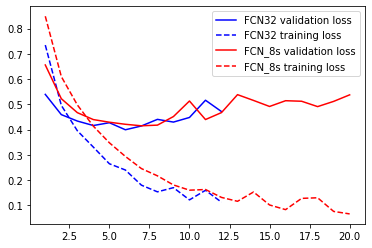

In [ ]:
#Losses
plt.plot(range(1,13), h_32['val_loss'], '-', color='blue', label='FCN32 validation loss')
plt.plot(range(1,13), h_32['loss'], '--', color='blue', label='FCN32 training loss')
plt.plot(range(1,21), h_8['val_loss'], '-', color='red', label='FCN_8s validation loss')
plt.plot(range(1,21), h_8['loss'], '--', color='red', label='FCN_8s training loss')
plt.legend()
plt.savefig('/content/FCN_loss.jpg')
plt.show()



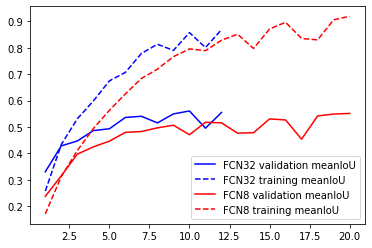

In [ ]:
#Mean_IOU
plt.plot(range(1,13), h_32['val_mean_IoU'], '-', color='blue', label='FCN32 validation meanIoU')
plt.plot(range(1,13), h_32['mean_IoU'], '--', color='blue', label='FCN32 training meanIoU')


plt.plot(range(1,21), h_8['val_meanIoU'], '-', color='red', label='FCN8 validation meanIoU')
plt.plot(range(1,21), h_8['meanIoU'], '--', color='red', label='FCN8 training meanIoU')

plt.legend()
plt.savefig('/content/FCN_IOU.jpg')

plt.show()